<a href="https://colab.research.google.com/github/nahumsa/GANs/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks


## Introduction

This model was proposed on the [article](https://arxiv.org/abs/1406.2661) by Goodfellow et al. There are multiple awesome references for this subject, I will try to list some: [GAN Series](https://medium.com/@jonathan_hui/gan-gan-series-2d279f906e7b) by Jonathan Hui, [Generative Deep Learning](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/) by David Foster. The code here is inspired by both of those.

The main idea is to use two Networks(Generator and Discriminator) to battle each other to see if one can generate an image that the other cannot percieve that is false.

The generator, as the name suggests, generates images from noise to trick the discriminator to think they are true. This poses a question, how should you train a model with this structure. 

What they proposed on the article is to separate the training into two parts, training each one separately. The trainin steps are:

- 1) To train the discriminator, we feed both fake and true images, labelling 0 and 1, thus we train the discriminator to output near 0 for fake images and 1 for true images.

- 2) To train the generator, we feed the output of the generator into the discriminator and force them to be 1 for the generator.

Thus to train the GAN is just to follow those two steps for a desired number of epochs.

Let's see how this is done in Keras.

## 0) Importing Dependencies

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 1) Building the generator

The role of the generator is to generate images through sampling from a random distribution. 

In [0]:
def build_generator(latent_dim, generator_initial_layer_size,
                    generator_conv_filters, 
                    generator_conv_kernel_size,
                    generator_upsample,
                    generator_conv_strides,
                    generator_dropout_rate=None,
                    generator_batch_norm_momentum=None):
  """ Build the GAN Generator without compiling.

  Parameters
  ------------------------------------------------------------------------------

  latent_dim(int): Latent Dimension.
  generator_initial_layer_size(list): The layer size of the image including 
  channels. Ex. [28,28,1]
  n_layers_generator(int): Number of convolutional layers on generator.

  """
  n_layers_generator = len(generator_conv_filters)
  
  assert n_layers_generator == len(generator_conv_kernel_size), ( 
         'Convolutional Kernel size should have the same length'
         + 'as convolutional filters.')  
  
  assert n_layers_generator == len(generator_upsample), ( 
         'Convolutional Kernel size should have the same length'
         + 'as upsampling layers.')
  
  assert n_layers_generator == len(generator_conv_strides), ( 
         'Convolutional strides should have the same length'
         + 'as convolutional filters')

  generator_input = layers.Input(shape=(latent_dim,), name='Gen_Input')
  x = generator_input
  x = layers.Dense(np.prod(generator_initial_layer_size), name='Gen_Dense_0')(x)
  
  if generator_batch_norm_momentum:
    x = layers.BatchNormalization(momentum = generator_batch_norm_momentum,
                                  name='Gen_BatchNorm_0')(x)
  
  x = layers.LeakyReLU(alpha=0.2, name='Gen_LReLU_0')(x)
  x = layers.Reshape(generator_initial_layer_size,
                     name='Ge_Reshape_0')(x)

  if generator_dropout_rate:
    x = layers.Dropout(generator_dropout_rate,
                       name='Gen_Dropout_0')(x)

  for i in range(n_layers_generator):
    
    if generator_upsample[i] == 2:
      x = layers.UpSampling2D(name=f'Gen_Upsampling_{i}')(x)
      x = layers.Conv2D(
          filters = generator_conv_filters[i],
          kernel_size= generator_conv_kernel_size[i],
          padding='same',
          name = f'Gen_conv_{str(i)}'
        )(x)
    
    else:
        x = layers.Conv2DTranspose(
            filters = generator_conv_filters[i]
            , kernel_size = generator_conv_kernel_size[i]
            , padding = 'same'
            , strides = generator_conv_strides[i]
            , name = 'generator_convT_' + str(i)            
            )(x)

    if i < n_layers_generator - 1:
      if generator_batch_norm_momentum:
        x = layers.BatchNormalization(momentum = generator_batch_norm_momentum,
                                      name=f'Gen_BatchNorm_{i+1}')(x)
      x = layers.LeakyReLU(alpha=0.2, name=f'Gen_LReLU_{i+1}')(x)
    
    else: #last layer
      x = layers.Activation('tanh', name='Gen_Activation_tanh')(x)

  generator_output = x
  
  return keras.models.Model(generator_input, generator_output, name='Generator')

## 2) Building the discriminator

For the discriminator we build a simple Fully Convolutional Nework (FCN) the input of the network is the image that you want to evaluate if it is real or fake. 

In [0]:
def build_discriminator(input_dim, discriminator_conv_filters,
                        discriminator_conv_kernel_size,
                        discriminator_conv_strides,
                        weight_init= keras.initializers.RandomNormal(mean=0., stddev=0.02),
                        discriminator_dropout_rate=None,
                        discriminator_batch_norm_momentum=None):
  """ Build the GAN Discriminator without compiling.

  Parameters
  ------------------------------------------------------------------------------

  input_dim(tuple): Latent Dimension.
  generator_initial_layer_size(list): The layer size of the image including 
  channels. Ex. [16,16,1]
  n_layers_generator(int): Number of convolutional layers on generator.

  """
  n_layers_discriminator = len(discriminator_conv_filters)
  assert n_layers_discriminator == len(discriminator_conv_kernel_size), ( 
         'Convolutional Kernel size should have the same length'
         + 'as convolutional filters')

  assert n_layers_discriminator == len(discriminator_conv_strides), ( 
         'Convolutional strides should have the same length'
         + 'as convolutional filters')

  discriminator_input = layers.Input(shape=input_dim, name='Disc_input')
  x = discriminator_input

  for i in range(n_layers_discriminator):
    x = layers.Conv2D(
        filters=discriminator_conv_filters[i],
        kernel_size=discriminator_conv_kernel_size[i],
        strides=discriminator_conv_strides[i],
        padding='same',
        name=f'Disc_conv_{i}'
        )(x)
    
    if discriminator_batch_norm_momentum and i>0:
      x = layers.BatchNormalization(momentum=discriminator_batch_norm_momentum,
                                    name=f'Disc_BatchNorm_{i}')(x)
    
    x = layers.LeakyReLU(alpha=0.3,
                         name=f'Disc_LeakyReLU_{i}')(x)
    
    if discriminator_dropout_rate:
      x = layers.Dropout(rate=discriminator_dropout_rate,
                         name=f'Disc_Dropout_{i}')(x)

  x = layers.Flatten(name='Disc_Flatten')(x)
  
  x = layers.Dense(1, activation='sigmoid',
                   kernel_initializer=weight_init,
                   name='Disc_Output')(x)
  
  discriminator_output = x
  
  return keras.models.Model(discriminator_input, discriminator_output, name='Discriminator')

## 3) Building the whole Model

The main trick on the GAN is the training, for this we follow what is explained on the introduction training first the discriminator and then the generator for a desired amount of epochs.  

For generating the GAN model, this code code is based on this [keras.io tutorial](https://keras.io/guides/customizing_what_happens_in_fit/).

In [0]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator 
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN,self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  def train_step(self, data):
     
    if isinstance(data, tuple):
      data = data[0]
    
    batch_size = tf.shape(data)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim),
                                             name='Rand_Latent_Vectors')
    
    #Generate fake images
    gen_images = self.generator(random_latent_vectors)

    #Combining fake and real images
    combined_images = tf.concat([gen_images, data],
                                axis=0)
    
    #Create labels for the images
    labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))],
                       axis=0)
    
    #Add noise to labels (?)
    labels += 0.05*tf.random.uniform(tf.shape(labels))

    #Training the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
      )
    
    #Sample points on the latent space 
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))

    #Force all images to be "real"
    forced_labels = tf.zeros(shape=(batch_size,1))

    #Training generator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(forced_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights)
    )
    return {"d_loss": d_loss, "g_loss":g_loss}
  
  def generate(self, n_samples):
    
    #Sample points on the latent space 
    random_latent_vectors = tf.random.normal(shape=(n_samples,self.latent_dim))
    predictions = self.generator(random_latent_vectors)
    
    return predictions

## 4) Data

For our example we will use MNIST images. 

In [0]:
batch_size = 128
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype('float32') / 255.
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

Initializing the generator and discriminator

It is interesting to note that your discriminator must have the same output as your image and every Upsampling layer grows by a factor of two.

In [38]:
# Generator Parameters
latent_dimension = 100
gen_initial_layer_size = (7,7,128)
gen_conv_filters = [128, 128, 256, 1]
gen_conv_kernel_size = [2, 2, 1, 1]
gen_upsample = [2, 2, 1, 1]
gen_conv_strides = [2, 2, 1, 1]
gen_dropout_rate = None
gen_batch_norm_momentum = 0.9

# Discriminator Parameters
input_dimension = all_digits.shape[1:]
disc_conv_filters = [8, 16, 32]
disc_conv_kernel_size = [3, 3, 3]
disc_conv_strides = [2, 2, 2]
disc_dropout_rate = None
disc_batch_norm_momentum = 0.9

gen = build_generator(latent_dim=latent_dimension, 
                    generator_initial_layer_size=gen_initial_layer_size, 
                    generator_conv_filters=gen_conv_filters, 
                    generator_conv_kernel_size=gen_conv_kernel_size, 
                    generator_upsample=gen_upsample,
                    generator_conv_strides=gen_conv_strides,
                    generator_dropout_rate=gen_dropout_rate, 
                    generator_batch_norm_momentum=gen_batch_norm_momentum)


disc = build_discriminator(input_dim=input_dimension, 
                        discriminator_conv_filters=disc_conv_filters, 
                        discriminator_conv_kernel_size=disc_conv_kernel_size, 
                        discriminator_conv_strides=disc_conv_strides, 
                        discriminator_dropout_rate=disc_dropout_rate, 
                        discriminator_batch_norm_momentum=disc_batch_norm_momentum)

gen.summary()
#disc.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
Gen_Dense_0 (Dense)          (None, 6272)              633472    
_________________________________________________________________
Gen_BatchNorm_0 (BatchNormal (None, 6272)              25088     
_________________________________________________________________
Gen_LReLU_0 (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
Ge_Reshape_0 (Reshape)       (None, 7, 7, 128)         0         
_________________________________________________________________
Gen_Upsampling_0 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
Gen_conv_0 (Conv2D)          (None, 14, 14, 128)       65

In [0]:
gan = GAN(discriminator=disc,
          generator=gen,
          latent_dim=latent_dimension)

gan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=0.0003), 
  g_optimizer=keras.optimizers.Adam(learning_rate=0.0004),
  loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
  )

In [0]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  """ Callback to show images at the end of each epoch
  """
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(10)
    print ('\nGenerated images after epoch {}\n'.format(epoch+1))

def show_predictions(n_to_show): 
  """ Helper function fo show data generated by the GAN.
  
  Parameters
  -----------------------------------------------------------------------------
  n_to_show(int): Number of showed images.

  """   
  G = gan.generate(n_to_show)
  plt.figure(figsize=(20, 20))
  for i in range(n_to_show):

    plt.subplot(1, n_to_show, i+1)
    plt.imshow(G[i,:,:,0], vmin=0, vmax=1, cmap="gray")    
    plt.axis('off')        
  plt.tight_layout()
  plt.show()

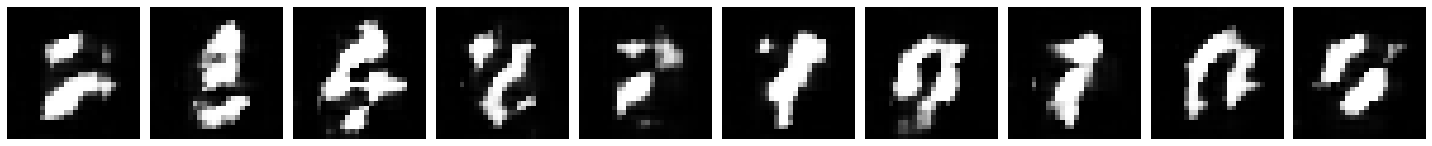


Generated images after epoch 10

547/547 [==============================] - 40s 73ms/step - d_loss: 0.6931 - g_loss: 0.7015


In [41]:
history = gan.fit(dataset, epochs=10,
                  callbacks=[DisplayCallback()])

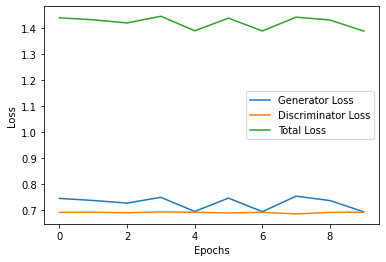

In [42]:
history = history.history
g_loss = np.array(history['g_loss'])
d_loss = np.array(history['d_loss'])
epochs = range(len(d_loss))

plt.plot(epochs, g_loss, label='Generator Loss')
plt.plot(epochs, d_loss, label='Discriminator Loss')
plt.plot(epochs, g_loss + d_loss, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
